In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [2]:
# -------------------------
# Datos
# -------------------------
clientes = {
    "A": (2, 3, 20),
    "B": (5, 7, 18),
    "C": (9, 4, 4),
    "D": (6, 2, 3),
    "E": (8, 8, 15),
    "F": (4, 9, 3),
    "G": (7, 11, 3),
    "H": (10, 10, 2)
}
# Formato: "Cliente": (x, y, demanda)

# Zonas
zonas = {
    1: {"xmin": 1, "xmax": 5, "ymin": 1, "ymax": 5},
    2: {"xmin": 6, "xmax": 11, "ymin": 3, "ymax": 9},
    3: {"xmin": 3, "xmax": 9, "ymin": 9, "ymax": 13}
}

In [3]:
# -------------------------
# Modelo
# -------------------------
m = gp.Model("Sabores_Selectos")

# Variables
x = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="x")
y = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(zonas.keys(), vtype=GRB.BINARY, name="z")

# Restricción: debe elegirse exactamente una zona
m.addConstr(gp.quicksum(z[k] for k in zonas) == 1)

# Restricciones de ubicación (big-M según zonas)
for k, zona in zonas.items():
    m.addConstr(zona["xmin"] * z[k] <= x)
    m.addConstr(x <= zona["xmax"] * z[k] + (1 - z[k]) * 1e5)
    m.addConstr(zona["ymin"] * z[k] <= y)
    m.addConstr(y <= zona["ymax"] * z[k] + (1 - z[k]) * 1e5)

# Función objetivo: minimizar distancia al cuadrado (ponderada por demanda)
m.setObjective(
    gp.quicksum(d * ((x - cx) ** 2 + (y - cy) ** 2) for cx, cy, d in clientes.values()),
    GRB.MINIMIZE
)

Set parameter Username
Set parameter LicenseID to value 2711715
Academic license - for non-commercial use only - expires 2026-09-22


In [4]:
# -------------------------
# Resolver
# -------------------------
m.optimize()

print(f"Ubicación óptima de la bodega: ({x.X:.2f}, {y.X:.2f})")
for k in zonas:
    if z[k].X > 0.5:
        print(f"La bodega se ubica en la Zona {k}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 5 columns and 27 nonzeros
Model fingerprint: 0x337008a7
Model has 2 quadratic objective terms
Variable types: 2 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [7e+02, 8e+02]
  QObjective range [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 8 rows and 0 columns
Presolve time: 0.03s
Presolved: 5 rows, 5 columns, 15 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 2 continuous, 3 integer (3 binary)
Found heuristic solution: objective 971.0000000
Found heuristic solution: objective 937.0000000

Root relaxation: objective 8.987500e+02, 5 iterations, 0.00 seconds (0.00 work units)

 

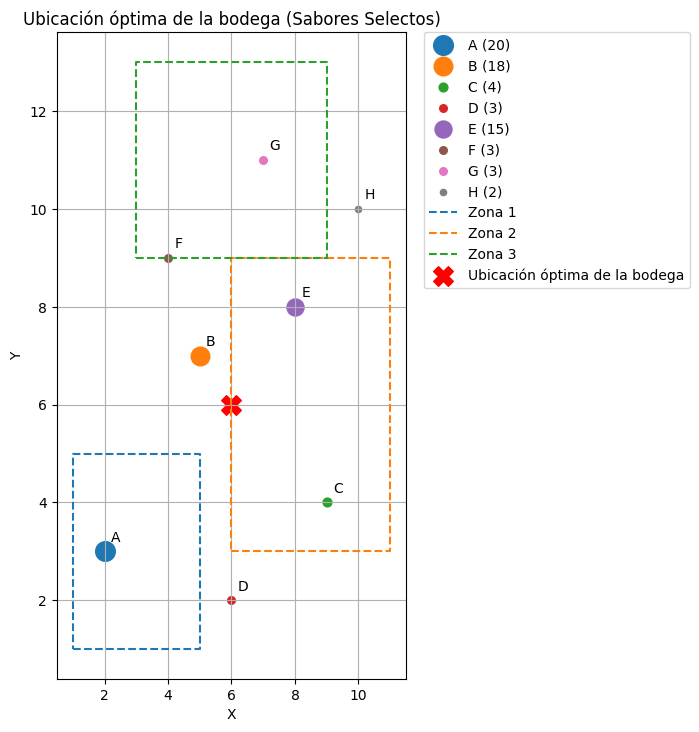

In [7]:
# -------------------------
# Graficar
# -------------------------
plt.figure(figsize=(7, 7))

# Graficar clientes
for name, (cx, cy, d) in clientes.items():
    plt.scatter(cx, cy, s=d*10, label=f"{name} ({d})")
    plt.text(cx+0.2, cy+0.2, name)

# Graficar zonas
for k, zona in zonas.items():
    plt.plot(
        [zona["xmin"], zona["xmax"], zona["xmax"], zona["xmin"], zona["xmin"]],
        [zona["ymin"], zona["ymin"], zona["ymax"], zona["ymax"], zona["ymin"]],
        linestyle="--", label=f"Zona {k}"
    )

# Graficar bodega
plt.scatter(x.X, y.X, c="red", marker="X", s=200, label="Ubicación óptima de la bodega")

plt.legend(
    bbox_to_anchor=(1.05, 1),   # mover la leyenda fuera del eje a la derecha
    loc='upper left',           # punto de anclaje
    borderaxespad=0.            # sin espacio extra
)
plt.tight_layout()  # ajusta automáticamente el gráfico para que no se corte
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Ubicación óptima de la bodega (Sabores Selectos)")
plt.grid(True)
plt.show()